**Project context** <br>This notebook is part of the project "Bookmakerspy", a project that aims at predicting football games results in the context of the English Premier League (based on data from 2014 to 2018) and ultimately beat bookmakers' odds.<br>
The current notebook "bookmakerspy_modelisation" is the third in a series of 4 notebooks. It is followed by "bookmakerspy_betting_strategy".<br>
**Notebook goal**<br>
This Notebook investigates the post-processed data (from the dataset 'df_results.csv' file) by applying various classification models:<br>
1- Selection of the most important features and model reduction<br>
2- Meta-parameters selection and use of comon classification models<br>
3- Comparison of model results applied on a dataset:<br>
        - without any modification<br>
        - with a feature selection<br> 
        - applying a dimension reduction<br>
   The best model is then compared with the best bookmaker predictions<br>

In [114]:
# Data Upload
import os
import pandas as pd
import numpy as np

os.getcwd() 

df = pd.read_csv('df_results.csv', index_col = 0)
df = df.reset_index(drop=True).set_index('match_id')
df.head()

,season,date,away_team_id,away_team_name,home_team_id,home_team_name,home_team_rating,home_won_contest,home_possession_percentage,home_total_throws,home_blocked_scoring_att,home_total_scoring_att,home_total_tackle,home_aerial_won,home_aerial_lost,home_won_corners,home_shot_off_target,home_ontarget_scoring_att,home_total_offside,home_post_scoring_att,home_att_pen_goal,home_penalty_save,HF,HY,HR,home_pass,home_accurate_pass,home_total_pass,goalkeeper_home_player_rating,defender_home_player_rating,midfielder_home_player_rating,forward_home_player_rating,FTHG_mean,away_team_rating,away_won_contest,away_possession_percentage,away_total_throws,away_blocked_scoring_att,away_total_scoring_att,away_total_tackle,away_aerial_won,away_aerial_lost,away_won_corners,away_shot_off_target,away_ontarget_scoring_att,away_total_offside,away_post_scoring_att,away_att_pen_goal,away_penalty_save,AF,AY,AR,away_pass,away_accurate_pass,away_total_pass,goalkeeper_away_player_rating,defender_away_player_rating,midfielder_away_player_rating,forward_away_player_rating,FTAG_mean,FTR,FTHG,FTAG,B365H,B365D,B365A,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,VCH,VCD,VCA,PSCH,PSCD,PSCA,Diff_def_home_fwd_away,Diff_def_home_mid_away,Diff_mil_home_att_away,Diff_mil_home_mid_away,Diff_mil_home_def_away,Diff_fwd_home_mid_away,Diff_fwd_home_def_away,Diff_Goal
match_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
829595,2014_2015,2014-10-04,167,Manchester City,24,Aston Villa,6.519762,6.333333,38.133333,23.666667,2.333333,9.000000,14.000000,11.666667,15.000000,5.000000,4.666667,2.000000,2.000000,0.666667,0.000000,0.0,10.333333,2.000000,0.000000,0.756784,281.000000,370.333333,6.586667,6.551667,6.670889,6.925000,0.666667,7.160476,11.333333,56.733333,20.000000,3.333333,16.000000,25.666667,13.333333,14.666667,4.666667,6.333333,6.333333,0.666667,0.666667,0.000000,0.0,10.666667,3.666667,0.000000,0.850091,516.333333,605.666667,6.693333,7.280000,7.134333,7.948333,2.666667,A,0.0,2.0,7.50,4.50,1.5,6.50,4.33,1.5,8.05,4.57,1.48,7.00,3.75,1.53,8.00,4.50,1.5,8.70,5.00,1.42,-1.396667,-0.582667,-1.277444,-0.463444,-1.277444,-0.209333,-1.023333,-2.0
829605,2014_2015,2014-10-04,162,Crystal Palace,214,Hull,6.802143,8.333333,41.300000,18.000000,2.000000,10.000000,24.333333,18.333333,19.000000,3.333333,3.666667,4.333333,0.333333,0.333333,0.333333,0.0,10.666667,1.333333,0.333333,0.783930,300.333333,381.333333,6.106667,7.147778,6.943000,7.081667,1.666667,6.832143,9.333333,28.100000,17.333333,2.666667,8.666667,24.000000,18.000000,19.666667,2.666667,2.000000,4.000000,1.333333,0.000000,0.333333,0.0,17.000000,2.333333,0.333333,0.634125,153.666667,241.333333,6.233333,6.933333,7.184833,7.183333,2.333333,H,2.0,0.0,2.10,3.50,3.8,2.05,3.40,4.0,2.12,3.44,3.89,2.10,3.10,3.80,2.10,3.40,3.9,2.18,3.45,3.67,-0.035556,-0.037056,-0.240333,-0.241833,-0.240333,-0.103167,-0.101667,2.0
829610,2014_2015,2014-10-04,184,Burnley,14,Leicester,6.957619,8.333333,37.066667,19.666667,3.000000,11.666667,18.666667,20.000000,19.333333,3.333333,5.000000,3.666667,2.333333,0.000000,0.666667,0.0,13.666667,1.666667,0.000000,0.759296,263.333333,346.666667,6.576667,7.047500,6.950000,7.531667,2.666667,6.458810,4.000000,45.700000,23.333333,4.333333,11.000000,13.000000,21.000000,22.000000,3.666667,4.666667,2.000000,1.333333,0.000000,0.000000,0.0,10.666667,2.000000,0.000000,0.759945,307.000000,403.666667,6.113333,6.861667,6.468500,6.205000,0.000000,D,2.0,2.0,1.80,3.75,5.0,1.80,3.60,5.0,1.79,3.72,5.16,1.80,3.25,5.00,1.80,3.70,5.0,1.72,4.05,5.20,0.842500,0.579000,0.745000,0.481500,0.745000,1.063167,1.326667,0.0
829615,2014_2015,2014-10-04,175,West Bromwich Albion,26,Liverpool,6.888462,9.333333,59.066667,20.000000,6.000000,18.000000,18.333333,17.666667,10.666667,5.666667,7.333333,4.666667,2.333333,0.666667,0.000000,0.0,8.333333,1.666667,0.000000,0.863823,509.000000,586.666667,6.523333,7.121667,7.099333,6.960000,1.000000,6.659325,5.333333,41.566667,16.666667,3.666667,11.333333,19.000000,9.333333,14.000000

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1425 entries, 829595 to 1190547
Data columns (total 89 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   season                         1425 non-null   object 
 1   date                           1425 non-null   object 
 2   away_team_id                   1425 non-null   int64  
 3   away_team_name                 1425 non-null   object 
 4   home_team_id                   1425 non-null   int64  
 5   home_team_name                 1425 non-null   object 
 6   home_team_rating               1425 non-null   float64
 7   home_won_contest               1425 non-null   float64
 8   home_possession_percentage     1425 non-null   float64
 9   home_total_throws              1425 non-null   float64
 10  home_blocked_scoring_att       1425 non-null   float64
 11  home_total_scoring_att         1425 non-null   float64
 12  home_total_tackle              1425 non-

The dataset is splited (training and test samples): X_train, X_test, y_train, y_test 
We train the different models from the 2014-2015 season up to the 2016-2017 season, model evaluation is made on the 
last season, that is the 2017-2018 season. 
The idea is to consider that after having trained our model we are at the beginning of season 2017 and start applying our models and beting strategy putting ourselve in real conditions. This gives reasonnable proportions: 75% of the dataset for the trainings and 25% for the tests. A classic random spliting can also be considered.

In [116]:
from sklearn.model_selection import train_test_split
# Features
feats_list = [ # Features for the 'home' team
       'home_team_rating', 'home_won_contest', 'home_possession_percentage', 'home_total_throws', 'home_blocked_scoring_att', 
       'home_total_scoring_att', 'home_total_tackle', 'home_aerial_won', 'home_aerial_lost', 'home_accurate_pass', 
       'home_total_pass', 'home_won_corners', 'home_shot_off_target', 'home_ontarget_scoring_att','home_total_offside', 
       'home_post_scoring_att', 'home_att_pen_goal', 'home_penalty_save', 'HF', 'HY', 'HR', 'home_pass', 
       'goalkeeper_home_player_rating', 'defender_home_player_rating', 'midfielder_home_player_rating', 'forward_home_player_rating', 'FTHG',       
               # Features for the 'away' team
       'away_team_rating', 'away_won_contest', 'away_possession_percentage', 'away_total_throws', 'away_blocked_scoring_att',
       'away_total_scoring_att', 'away_total_tackle', 'away_aerial_won', 'away_aerial_lost', 'away_accurate_pass', 
       'away_total_pass', 'away_won_corners', 'away_shot_off_target', 'away_ontarget_scoring_att', 'away_total_offside', 
       'away_post_scoring_att', 'away_att_pen_goal', 'away_penalty_save', 'AF', 'AY', 'AR', 'away_pass',
       'goalkeeper_away_player_rating', 'defender_away_player_rating', 'midfielder_away_player_rating', 'forward_away_player_rating', 'FTAG',
        # Bookmakers odds
        # 'B365H', 'B365D', 'B365A', 'LBH', 'LBD', 'LBA', 'PSH', 'PSD',
        # 'PSA', 'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA', 'PSCH', 'PSCD', 'PSCA'
    
        # Team Comparison
       'Diff_def_home_fwd_away', 'Diff_def_home_mid_away', 'Diff_mil_home_att_away', 'Diff_mil_home_mid_away',
       'Diff_mil_home_def_away', 'Diff_fwd_home_mid_away', 'Diff_fwd_home_def_away', 'Diff_Goal']
       
# Target
target_list = 'FTR'

# Split by considering last season as target
#Train = df[df['season']!='2017_2018']
#Test  = df[df['season']=='2017_2018']
#X_train = Train[feats_list]
#X_test  = Test[feats_list]
#y_train = Train[target_list].reset_index(drop=True)
#y_test  = Test[target_list].reset_index(drop=True)


# Split by using shuffle parameter of train_test_split function
data = df[feats_list]
target = df[target_list]

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, shuffle = False, random_state=789)

In [27]:
# Draw results are filtered, they are not predicted by the bookmakers. This filter would focus 
#to_drop =y_train[y_train=='D' ].index
#X_train = X_train.drop(to_drop,axis=0)

In [117]:
# Dataframe display
pd.set_option('display.max_columns', None)
df.head()

,season,date,away_team_id,away_team_name,home_team_id,home_team_name,home_team_rating,home_won_contest,home_possession_percentage,home_total_throws,home_blocked_scoring_att,home_total_scoring_att,home_total_tackle,home_aerial_won,home_aerial_lost,home_won_corners,home_shot_off_target,home_ontarget_scoring_att,home_total_offside,home_post_scoring_att,home_att_pen_goal,home_penalty_save,HF,HY,HR,home_pass,home_accurate_pass,home_total_pass,goalkeeper_home_player_rating,defender_home_player_rating,midfielder_home_player_rating,forward_home_player_rating,FTHG_mean,away_team_rating,away_won_contest,away_possession_percentage,away_total_throws,away_blocked_scoring_att,away_total_scoring_att,away_total_tackle,away_aerial_won,away_aerial_lost,away_won_corners,away_shot_off_target,away_ontarget_scoring_att,away_total_offside,away_post_scoring_att,away_att_pen_goal,away_penalty_save,AF,AY,AR,away_pass,away_accurate_pass,away_total_pass,goalkeeper_away_player_rating,defender_away_player_rating,midfielder_away_player_rating,forward_away_player_rating,FTAG_mean,FTR,FTHG,FTAG,B365H,B365D,B365A,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,VCH,VCD,VCA,PSCH,PSCD,PSCA,Diff_def_home_fwd_away,Diff_def_home_mid_away,Diff_mil_home_att_away,Diff_mil_home_mid_away,Diff_mil_home_def_away,Diff_fwd_home_mid_away,Diff_fwd_home_def_away,Diff_Goal
match_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
829595,2014_2015,2014-10-04,167,Manchester City,24,Aston Villa,6.519762,6.333333,38.133333,23.666667,2.333333,9.000000,14.000000,11.666667,15.000000,5.000000,4.666667,2.000000,2.000000,0.666667,0.000000,0.0,10.333333,2.000000,0.000000,0.756784,281.000000,370.333333,6.586667,6.551667,6.670889,6.925000,0.666667,7.160476,11.333333,56.733333,20.000000,3.333333,16.000000,25.666667,13.333333,14.666667,4.666667,6.333333,6.333333,0.666667,0.666667,0.000000,0.0,10.666667,3.666667,0.000000,0.850091,516.333333,605.666667,6.693333,7.280000,7.134333,7.948333,2.666667,A,0.0,2.0,7.50,4.50,1.5,6.50,4.33,1.5,8.05,4.57,1.48,7.00,3.75,1.53,8.00,4.50,1.5,8.70,5.00,1.42,-1.396667,-0.582667,-1.277444,-0.463444,-1.277444,-0.209333,-1.023333,-2.0
829605,2014_2015,2014-10-04,162,Crystal Palace,214,Hull,6.802143,8.333333,41.300000,18.000000,2.000000,10.000000,24.333333,18.333333,19.000000,3.333333,3.666667,4.333333,0.333333,0.333333,0.333333,0.0,10.666667,1.333333,0.333333,0.783930,300.333333,381.333333,6.106667,7.147778,6.943000,7.081667,1.666667,6.832143,9.333333,28.100000,17.333333,2.666667,8.666667,24.000000,18.000000,19.666667,2.666667,2.000000,4.000000,1.333333,0.000000,0.333333,0.0,17.000000,2.333333,0.333333,0.634125,153.666667,241.333333,6.233333,6.933333,7.184833,7.183333,2.333333,H,2.0,0.0,2.10,3.50,3.8,2.05,3.40,4.0,2.12,3.44,3.89,2.10,3.10,3.80,2.10,3.40,3.9,2.18,3.45,3.67,-0.035556,-0.037056,-0.240333,-0.241833,-0.240333,-0.103167,-0.101667,2.0
829610,2014_2015,2014-10-04,184,Burnley,14,Leicester,6.957619,8.333333,37.066667,19.666667,3.000000,11.666667,18.666667,20.000000,19.333333,3.333333,5.000000,3.666667,2.333333,0.000000,0.666667,0.0,13.666667,1.666667,0.000000,0.759296,263.333333,346.666667,6.576667,7.047500,6.950000,7.531667,2.666667,6.458810,4.000000,45.700000,23.333333,4.333333,11.000000,13.000000,21.000000,22.000000,3.666667,4.666667,2.000000,1.333333,0.000000,0.000000,0.0,10.666667,2.000000,0.000000,0.759945,307.000000,403.666667,6.113333,6.861667,6.468500,6.205000,0.000000,D,2.0,2.0,1.80,3.75,5.0,1.80,3.60,5.0,1.79,3.72,5.16,1.80,3.25,5.00,1.80,3.70,5.0,1.72,4.05,5.20,0.842500,0.579000,0.745000,0.481500,0.745000,1.063167,1.326667,0.0
829615,2014_2015,2014-10-04,175,West Bromwich Albion,26,Liverpool,6.888462,9.333333,59.066667,20.000000,6.000000,18.000000,18.333333,17.666667,10.666667,5.666667,7.333333,4.666667,2.333333,0.666667,0.000000,0.0,8.333333,1.666667,0.000000,0.863823,509.000000,586.666667,6.523333,7.121667,7.099333,6.960000,1.000000,6.659325,5.333333,41.566667,16.666667,3.666667,11.333333,19.000000,9.333333,14.000000

In [118]:
#Standardisation
from sklearn.preprocessing import StandardScaler     

scaler = StandardScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index = X_train.index, columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index = X_test.index, columns = X_test.columns)

In [119]:
print('Number of features :', len(X_train.columns))

Number of features : 62


# 1 Dimension reduction of the dataset

## 1.1 Wrapper RFECV

In [120]:
# The function RFECV is considered as it allows the used of various folds. We ahave a classification problem
# and a tree classifier is used with the RFECV.

from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=123)
crossval = KFold(n_splits = 6, random_state = 2, shuffle = True)
rfecv = RFECV(estimator=dt, cv = crossval, step=1)
rfecv.fit(X_train, y_train)

RFECV(cv=KFold(n_splits=6, random_state=2, shuffle=True),
      estimator=DecisionTreeClassifier(random_state=123))

In [121]:
print('Optimal number of features :', rfecv.n_features_)

Optimal number of features : 1


In [122]:
print('Deleted features :', X_train.columns[~rfecv.support_])
list_rfecv = X_train.columns[~rfecv.support_]

Deleted features : Index(['home_team_rating', 'home_won_contest', 'home_possession_percentage',
       'home_total_throws', 'home_blocked_scoring_att',
       'home_total_scoring_att', 'home_total_tackle', 'home_aerial_won',
       'home_aerial_lost', 'home_accurate_pass', 'home_total_pass',
       'home_won_corners', 'home_shot_off_target', 'home_ontarget_scoring_att',
       'home_total_offside', 'home_post_scoring_att', 'home_att_pen_goal',
       'home_penalty_save', 'HF', 'HY', 'HR', 'home_pass',
       'goalkeeper_home_player_rating', 'defender_home_player_rating',
       'midfielder_home_player_rating', 'forward_home_player_rating', 'FTHG',
       'away_team_rating', 'away_won_contest', 'away_possession_percentage',
       'away_total_throws', 'away_blocked_scoring_att',
       'away_total_scoring_att', 'away_total_tackle', 'away_aerial_won',
       'away_aerial_lost', 'away_accurate_pass', 'away_total_pass',
       'away_won_corners', 'away_shot_off_target', 'away_ontarget_scor

/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


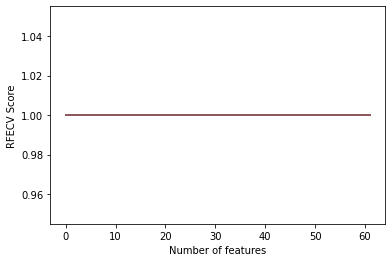

In [123]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.xlabel("Number of features")
plt.ylabel("RFECV Score")
plt.plot(rfecv.grid_scores_);
plt.show()
# The integer n_features represents the number of features selected by the algorithm.

# grid_scores_ gives the mean score by cross-validation for the various iterations. It allows to plot the RFECV score as a 
# fucntion of the feature number

## 1.2 Logistic Regression with Elasticnet

In [36]:
from sklearn.feature_selection import SelectFromModel
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, cross_val_score

# Logistic regression via easticnet for the feature selection
parametres = {'C':[0.1,1,3],'l1_ratio': [0.1, 0.25, 0.8, 0.99]}
clf = linear_model.LogisticRegression(penalty = 'elasticnet', solver = 'saga', max_iter = 2000)
# High value of max_iter is necessary to ensure convergence
grid_clf = GridSearchCV(estimator=clf, param_grid=parametres)

In [37]:
grille = grid_clf.fit(X_train,y_train)
print('Best parameters:',grid_clf.best_params_) 
# Remark: Minimum value for C and maximum for l1_ratio are selected. No out of bounds values could be found

/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/

Best parameters: {'C': 0.1, 'l1_ratio': 0.8}


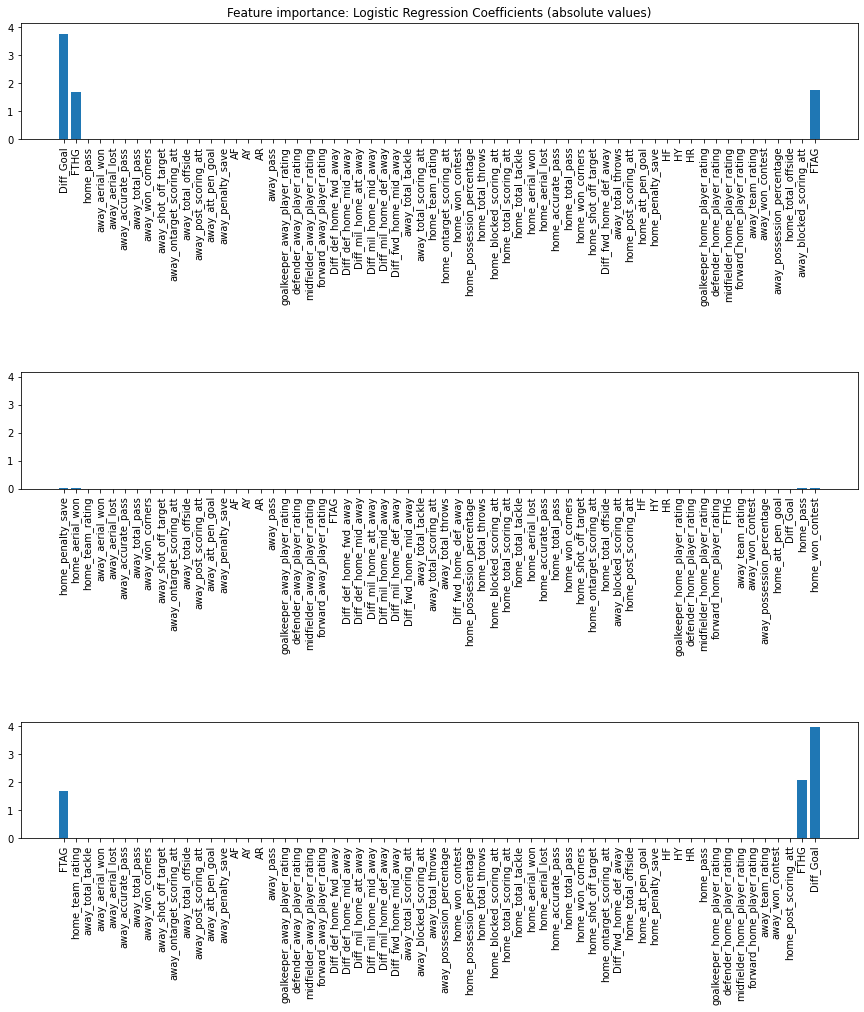

In [38]:
# The feature importance is plotted for the 3 regressions performed (for the 3 possible classes of the target)
# Features to be deleted have a zero coefficient
optimal_clf = grid_clf.best_estimator_
elast_coef = optimal_clf.coef_

ticks = np.arange(0, len(elast_coef[0,:]))
fig, [ax1, ax2, ax3] = plt.subplots(3,1,figsize=(15,15), sharex = False, sharey = True)
ax1.bar(ticks, np.abs(elast_coef[0,elast_coef[0,:].argsort()]))
ax1.set_xticks(ticks)
ax1.set_xticklabels(X_train.columns.values[elast_coef[0,:].argsort()], rotation='vertical')

ax2.bar(ticks, np.abs(elast_coef[1,elast_coef[1,:].argsort()]))
ax2.set_xticks(ticks)
ax2.set_xticklabels(X_train.columns.values[elast_coef[1,:].argsort()], rotation='vertical')

ax3.bar(ticks, np.abs(elast_coef[2,elast_coef[2,:].argsort()]))
ax3.set_xticks(ticks)
ax3.set_xticklabels(X_train.columns.values[elast_coef[2,:].argsort()], rotation='vertical')
ax1.set_title("Feature importance: Logistic Regression Coefficients (absolute values)")
plt.subplots_adjust(hspace= 2)
plt.show()

## 1.3 PCA

In [39]:
from sklearn.decomposition import PCA

# First, the optimal number of vectors to represent the dataset is searched
data = df[feats_list]
pca = PCA(n_components = 6)
pca.fit(data)

PCA(n_components=6)

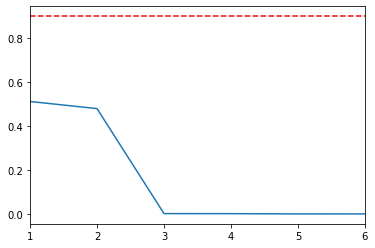

In [40]:
plt.figure()
plt.xlim(1,6)
plt.plot(np.array(range(1,7)),pca.explained_variance_ratio_);
plt.axhline(y = 0.9, color ='r', linestyle = '--')

In [41]:
pca = PCA(n_components = 0.9)
pca.fit(data)
print("Number of components:", pca.n_components_)

Number of components: 2


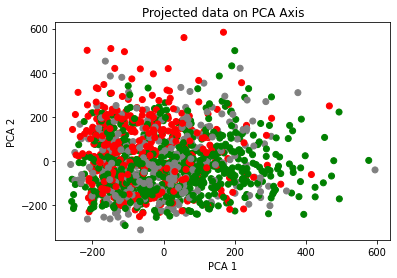

Explained standard deviation 0.99


In [42]:
# As only 2 components are enough, a 2D vizualisation of the data in the reduced space is possible. 

# PCA 2D plot colored by labels:
pca_2D = PCA(n_components = 2)
data_2D_pca = pca_2D.fit_transform(data)
target = df[target_list].values

fig = plt.figure()
ax = fig.add_subplot(111)
colors = {'A':'red', 'D':'gray', 'H':'green'}
ax.scatter(data_2D_pca[:, 0], data_2D_pca[:, 1], c = df[target_list].map(colors))

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_title("Projected data on PCA Axis")

plt.show();
print("Explained standard deviation", round(pca.explained_variance_ratio_.sum(),2))


In [43]:
# It is difficult to separate the different labels in distinct zones using a PCA reduction 

## 1.4 LDA

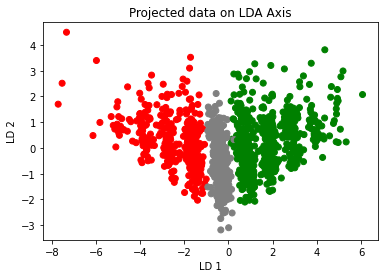

In [44]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA()
target = df[target_list].values
data_2D_lda = lda.fit_transform(data, target)

plt.show()
fig = plt.figure()
ax = fig.add_subplot(111)
colors = {'A':'red', 'D':'gray', 'H':'green'}
ax.scatter(data_2D_lda[:, 0], data_2D_lda[:, 1], c = df[target_list].map(colors))
ax.set_xlabel('LD 1')
ax.set_ylabel('LD 2')
 
ax.set_title("Projected data on LDA Axis")
plt.show();


In [45]:
# It is difficult to separate the different labels in distinct zones using a LDA reduction 

## 1.5 Manifold - tNSE

/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


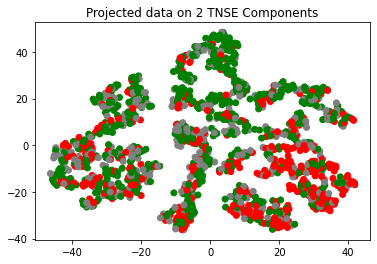

In [46]:
from sklearn.manifold import Isomap, TSNE

tsne = TSNE(n_components=2, method = 'barnes_hut')
dataTSNE = tsne.fit_transform(data)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(dataTSNE[:, 0], dataTSNE[:, 1],  c = df[target_list].map(colors))
ax.set_title("Projected data on 2 TNSE Components")
plt.show();

## 1.6 Manifold - IsoMap

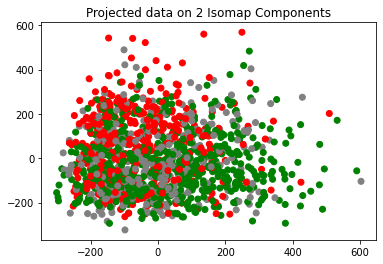

In [47]:
isomap = Isomap(n_neighbors=50, n_components=2)
dataISO = isomap.fit_transform(data)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(dataISO[:, 0], dataISO[:, 1],  c =df[target_list].map(colors))
ax.set_title("Projected data on 2 Isomap Components")
plt.show();

In [48]:
# There is no particular method that seems to separate the labels (this does not mean that there are not efficients).

In the rest, 3 different datasets are considered:
- A non reduced dataset: the suffix "_NR" will be used to specify variables associated with this dataset.

- A dataset with selected features via the logistic regression deleting features with zero coefficient of importance. A suffix "_FS" will be used to specify variables associated with this dataset.

- A reduced dimension dataset: the suffix "_R" will be used to specify variables associated with this dataset.

In [49]:
# Dataset _NR
X_train_NR = X_train
X_test_NR = X_test

In [50]:
# Dataset _FS

# Number of columns having a zero coefficient of importance (for each regression) 
print(np.size(np.where(optimal_clf.coef_[0,:]==0)))
print(np.size(np.where(optimal_clf.coef_[1,:]==0)))
print(np.size(np.where(optimal_clf.coef_[2,:]==0)))

57
58
59


In [51]:
# Columns in common:
del_col_0 = set(X_train.columns.values[np.where(optimal_clf.coef_[0,:]==0)])
del_col_1 = set(X_train.columns.values[np.where(optimal_clf.coef_[1,:]==0)])
del_col_2 = set(X_train.columns.values[np.where(optimal_clf.coef_[2,:]==0)])

print('Number of columns to be deleted:',len(del_col_0.intersection(del_col_1, del_col_2)),'\n')
print('Variables to be deleted:')
print(del_col_0.intersection(del_col_1, del_col_2))

Number of columns to be deleted: 54 

Variables to be deleted:
{'home_accurate_pass', 'goalkeeper_away_player_rating', 'goalkeeper_home_player_rating', 'home_total_offside', 'away_penalty_save', 'home_total_scoring_att', 'away_total_scoring_att', 'forward_home_player_rating', 'away_shot_off_target', 'away_possession_percentage', 'away_total_pass', 'AF', 'away_ontarget_scoring_att', 'home_possession_percentage', 'home_ontarget_scoring_att', 'HY', 'home_total_throws', 'away_won_corners', 'midfielder_away_player_rating', 'home_total_pass', 'Diff_mil_home_def_away', 'away_att_pen_goal', 'Diff_def_home_mid_away', 'away_won_contest', 'AR', 'midfielder_home_player_rating', 'defender_home_player_rating', 'away_total_throws', 'home_blocked_scoring_att', 'away_accurate_pass', 'Diff_fwd_home_mid_away', 'home_aerial_lost', 'away_post_scoring_att', 'away_aerial_lost', 'home_att_pen_goal', 'away_total_tackle', 'home_shot_off_target', 'AY', 'defender_away_player_rating', 'home_won_corners', 'HR', 'ho

In [52]:
to_drop = list(del_col_0.intersection(del_col_1, del_col_2))
X_train_FS = X_train.drop(to_drop, axis=1)
X_test_FS  = X_test.drop(to_drop, axis=1)

In [53]:
# Dataset _R
X_train_R = pca.fit_transform(X_train)
X_test_R = pca.transform(X_test)

# 2 - Classification models

In this section the most comon algorithm are tested for each dataset previously created.
For each case, a confusion matrix and a classification report is produced in order to compare the models and measure the benefits of using a reduced dataset or a dataset with selected features.

## 2.1 Logistic regression

In [54]:
from sklearn.metrics import classification_report 
parametres = {'C':[0.05,0.1,1,3],'l1_ratio': [0.01, 0.1, 0.2, 0.5, 0.99]}

clf_NR = linear_model.LogisticRegression(penalty = 'elasticnet', solver = 'saga',max_iter = 2000)
clf_FS = linear_model.LogisticRegression(penalty = 'elasticnet', solver = 'saga',max_iter = 2000)
clf_R  = linear_model.LogisticRegression(penalty = 'elasticnet', solver = 'saga',max_iter = 2000)

grid_clf_NR = GridSearchCV(estimator=clf_NR, param_grid=parametres)
grid_clf_FS = GridSearchCV(estimator=clf_FS, param_grid=parametres)
grid_clf_R = GridSearchCV(estimator=clf_R, param_grid=parametres)

grid_clf_NR.fit(X_train_NR,y_train)
grid_clf_FS.fit(X_train_FS,y_train)
grid_clf_R.fit(X_train_R,y_train)

print('Best parameters, non reduced dataset:',grid_clf_NR.best_params_) 
print('Best parameters, dataset with feature reduction:',grid_clf_FS.best_params_) 
print('Best parameters, reduced dataset:',grid_clf_R.best_params_) 
# Remark: Minimum value for C and maximum for l1_ratio are selected. No out of bounds values could be found

/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/

Best parameters, non reduced dataset: {'C': 0.05, 'l1_ratio': 0.5}
Best parameters, dataset with feature reduction: {'C': 0.05, 'l1_ratio': 0.5}
Best parameters, reduced dataset: {'C': 1, 'l1_ratio': 0.01}


In [55]:
y_pred_cfl_NR = grid_clf_NR.predict(X_test_NR)
y_pred_cfl_FS = grid_clf_FS.predict(X_test_FS)
y_pred_cfl_R  = grid_clf_R.predict(X_test_R)

In [56]:
# Classification report / Results for the reduced dataset are better / Draws are not predicted
print('Non reduced Dataset (NR):')
print(classification_report(y_test, pd.DataFrame(y_pred_cfl_NR)))
print('Dataset with selected features (FS):')
print(classification_report(y_test, pd.DataFrame(y_pred_cfl_FS)))
print('Reduced Dataset (R):')
print(classification_report(y_test, pd.DataFrame(y_pred_cfl_R)))

Non reduced Dataset (NR):
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        92
           D       1.00      1.00      1.00        89
           H       1.00      1.00      1.00       152

    accuracy                           1.00       333
   macro avg       1.00      1.00      1.00       333
weighted avg       1.00      1.00      1.00       333

Dataset with selected features (FS):
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        92
           D       1.00      1.00      1.00        89
           H       1.00      1.00      1.00       152

    accuracy                           1.00       333
   macro avg       1.00      1.00      1.00       333
weighted avg       1.00      1.00      1.00       333

Reduced Dataset (R):
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        92
           D       1.00      1.00      1.00  

In [57]:
# Confusion matrix
print('Non reduced Dataset (NR):')
pd.crosstab(y_test, y_pred_cfl_NR, rownames=['Real'], colnames=['Predicted'])

Non reduced Dataset (NR):


Predicted,A,D,H
Real,,,
A,92,0,0
D,0,89,0
H,0,0,152


In [58]:
print('Dataset with selected features (FS):')
pd.crosstab(y_test,y_pred_cfl_FS, rownames=['Real'], colnames=['Predicted'])

Dataset with selected features (FS):


Predicted,A,D,H
Real,,,
A,92,0,0
D,0,89,0
H,0,0,152


In [59]:
print('Reduced Dataset (R):')
pd.crosstab(y_test, y_pred_cfl_R, rownames=['Real'], colnames=['Predicted'])

Reduced Dataset (R):


Predicted,A,D,H
Real,,,
A,92,0,0
D,0,89,0
H,0,0,152


In [60]:
# Score comparison between the test and train dataset (overfitting check)
print('Score on (Test, Train) datasets, Non reduced Dataset (NR): (',grid_clf_NR.score(X_train_NR, y_train),' ,', grid_clf_NR.score(X_test, y_test) ,' )')
print('Score on (Test, Train) datasets, Selected Features (FS): (', grid_clf_FS.score(X_train_FS, y_train),' ,', grid_clf_FS.score(X_test_FS, y_test) ,' )')
print('Score on (Test, Train) datasets, Reduced Dataset (R): (',grid_clf_R.score(X_train_R, y_train),' ,' ,grid_clf_R.score(X_test_R, y_test) ,' )')

Score on (Test, Train) datasets, Non reduced Dataset (NR): ( 1.0  , 1.0  )
Score on (Test, Train) datasets, Selected Features (FS): ( 1.0  , 1.0  )
Score on (Test, Train) datasets, Reduced Dataset (R): ( 1.0  , 1.0  )


## 2.2 K plus proches Voisins

In [61]:
from sklearn import neighbors
# Best parameters selection
parametres = {'n_neighbors': [10, 20, 30, 40, 50], 'metric': ['manhattan', 'chebyshev', 'minkowski', 'l1' , 'l2'] }

knn_NR = neighbors.KNeighborsClassifier()
knn_FS = neighbors.KNeighborsClassifier()
knn_R  = neighbors.KNeighborsClassifier()

grid_knn_NR = GridSearchCV(estimator=knn_NR, param_grid=parametres)
grid_knn_FS = GridSearchCV(estimator=knn_FS, param_grid=parametres)
grid_knn_R = GridSearchCV(estimator=knn_R, param_grid=parametres)

grid_knn_NR.fit(X_train_NR,y_train)
grid_knn_FS.fit(X_train_FS,y_train)
grid_knn_R.fit(X_train_R,y_train)

print('Best parameters, non reduced dataset:',grid_knn_NR.best_params_) 
print('Best parameters, dataset with feature reduction:',grid_knn_FS.best_params_) 
print('Best parameters, reduced dataset:',grid_knn_R.best_params_) 

Best parameters, non reduced dataset: {'metric': 'manhattan', 'n_neighbors': 20}
Best parameters, dataset with feature reduction: {'metric': 'manhattan', 'n_neighbors': 20}
Best parameters, reduced dataset: {'metric': 'minkowski', 'n_neighbors': 30}


In [62]:
y_pred_knn_NR = grid_knn_NR.predict(X_test_NR)
y_pred_knn_FS = grid_knn_FS.predict(X_test_FS)
y_pred_knn_R  = grid_knn_R.predict(X_test_R)

In [63]:
# Classification reports / Results for the 3 datasets are similars (the best being obtained for the non reduced dataset) / Few draws are preducted but with a low recall score
print('Non reduced Dataset (NR):')
print(classification_report(y_test, pd.DataFrame(y_pred_knn_NR)))
print('Dataset with Selected Features (FS):')
print(classification_report(y_test, pd.DataFrame(y_pred_knn_FS)))
print('Reduced Dataset (R):')
print(classification_report(y_test, pd.DataFrame(y_pred_knn_R)))

Non reduced Dataset (NR):
              precision    recall  f1-score   support

           A       0.71      0.74      0.72        92
           D       0.70      0.34      0.45        89
           H       0.73      0.93      0.82       152

    accuracy                           0.72       333
   macro avg       0.71      0.67      0.67       333
weighted avg       0.72      0.72      0.70       333

Dataset with Selected Features (FS):
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        92
           D       1.00      0.99      0.99        89
           H       0.99      1.00      1.00       152

    accuracy                           1.00       333
   macro avg       1.00      1.00      1.00       333
weighted avg       1.00      1.00      1.00       333

Reduced Dataset (R):
              precision    recall  f1-score   support

           A       0.70      0.76      0.73        92
           D       0.70      0.18      0.29  

In [64]:
# Confusion matrix
print('Non reduced Dataset (NR):')
pd.crosstab(y_test,y_pred_knn_NR, rownames=['Real'], colnames=['Predicted'])

Non reduced Dataset (NR):


Predicted,A,D,H
Real,,,
A,68,11,13
D,20,30,39
H,8,2,142


In [65]:
print('Dataset with selected features (FS):')
pd.crosstab(y_test, y_pred_knn_FS, rownames=['Real'], colnames=['Predicted'])

Dataset with selected features (FS):


Predicted,A,D,H
Real,,,
A,92,0,0
D,0,88,1
H,0,0,152


In [66]:
print('Reduced Dataset (R):')
pd.crosstab(y_test, y_pred_knn_R, rownames=['Real'], colnames=['Predicted'])

Reduced Dataset (R):


Predicted,A,D,H
Real,,,
A,70,7,15
D,20,16,53
H,10,0,142


In [67]:
# Score comparison between the test and train dataset (overfitting check)
print('Score on (Test, Train) datasets, Non reduced Dataset (NR): (',grid_knn_NR.score(X_train_NR, y_train),' ,', grid_knn_NR.score(X_test, y_test) ,' )')
print('Score on (Test, Train) datasets, Selected Features (FS): (', grid_knn_FS.score(X_train_FS, y_train),' ,', grid_knn_FS.score(X_test_FS, y_test) ,' )')
print('Score on (Test, Train) datasets, Reduced Dataset (R): (',grid_knn_R.score(X_train_R, y_train),' ,' ,grid_knn_R.score(X_test_R, y_test) ,' )')

Score on (Test, Train) datasets, Non reduced Dataset (NR): ( 0.7863590772316951  , 0.7207207207207207  )
Score on (Test, Train) datasets, Selected Features (FS): ( 0.995987963891675  , 0.996996996996997  )
Score on (Test, Train) datasets, Reduced Dataset (R): ( 0.7382146439317954  , 0.6846846846846847  )


## 2.3 SVM

In [68]:
from sklearn import svm
from sklearn import model_selection

parametres = {'C':[0.1,1,3], 'kernel':['rbf','linear'], 'gamma':[0.005, 0.1, 0.5]}# Cross validation

clf_svm_NR = svm.SVC(probability=True)
clf_svm_FS = svm.SVC(probability=True)
clf_svm_R = svm.SVC(probability=True)

grid_clf_svm_NR = model_selection.GridSearchCV(estimator=clf_svm_NR, param_grid=parametres)
grid_clf_svm_FS = model_selection.GridSearchCV(estimator=clf_svm_FS, param_grid=parametres)
grid_clf_svm_R  = model_selection.GridSearchCV(estimator=clf_svm_R, param_grid=parametres)

grid_clf_svm_NR.fit(X_train_NR,y_train)
grid_clf_svm_FS.fit(X_train_FS,y_train)
grid_clf_svm_R.fit(X_train_R,y_train)


print('Best parameters, non reduced dataset:',grid_clf_svm_NR.best_params_) 
print('Best parameters, dataset with feature reduction:',grid_clf_svm_FS.best_params_) 
print('Best parameters, reduced dataset:',grid_clf_svm_R.best_params_) 

Best parameters, non reduced dataset: {'C': 0.1, 'gamma': 0.005, 'kernel': 'linear'}
Best parameters, dataset with feature reduction: {'C': 0.1, 'gamma': 0.005, 'kernel': 'linear'}
Best parameters, reduced dataset: {'C': 0.1, 'gamma': 0.005, 'kernel': 'linear'}


In [69]:
y_pred_clf_svm_NR = grid_clf_svm_NR.predict(X_test_NR)
y_pred_clf_svm_FS = grid_clf_svm_FS.predict(X_test_FS)
y_pred_clf_svm_R  = grid_clf_svm_R.predict(X_test_R)

In [70]:
# Classification reports / Results for the 3 datasets are similars / No Draws predicted except for the dataset with feature selection
print('Non reduced Dataset (NR):')
print(classification_report(y_test, pd.DataFrame(y_pred_clf_svm_NR)))
print('Dataset with selected features (FS):')
print(classification_report(y_test, pd.DataFrame(y_pred_clf_svm_FS)))
print('Reduced Dataset (R):')
print(classification_report(y_test, pd.DataFrame(y_pred_clf_svm_R)))

Non reduced Dataset (NR):
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        92
           D       1.00      1.00      1.00        89
           H       1.00      1.00      1.00       152

    accuracy                           1.00       333
   macro avg       1.00      1.00      1.00       333
weighted avg       1.00      1.00      1.00       333

Dataset with selected features (FS):
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        92
           D       1.00      1.00      1.00        89
           H       1.00      1.00      1.00       152

    accuracy                           1.00       333
   macro avg       1.00      1.00      1.00       333
weighted avg       1.00      1.00      1.00       333

Reduced Dataset (R):
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        92
           D       1.00      1.00      1.00  

In [71]:
# Confusion matrix
print('Non reduced Dataset (NR):')
pd.crosstab(y_test,y_pred_clf_svm_NR, rownames=['Real'], colnames=['Predicted'])

Non reduced Dataset (NR):


Predicted,A,D,H
Real,,,
A,92,0,0
D,0,89,0
H,0,0,152


In [72]:
print('Dataset with selected features (FS):')
pd.crosstab(y_test, y_pred_clf_svm_FS, rownames=['Real'], colnames=['Predicted'])

Dataset with selected features (FS):


Predicted,A,D,H
Real,,,
A,92,0,0
D,0,89,0
H,0,0,152


In [73]:
print('Reduced Dataset (R):')
pd.crosstab(y_test, y_pred_clf_svm_R, rownames=['Real'], colnames=['Predicted'])

Reduced Dataset (R):


Predicted,A,D,H
Real,,,
A,92,0,0
D,0,89,0
H,0,0,152


In [74]:
# Score comparison between the test and train dataset (overfitting check)
print('Score on (Test, Train) datasets, Non reduced Dataset (NR): (',grid_clf_svm_NR.score(X_train_NR, y_train),' ,', grid_clf_svm_NR.score(X_test, y_test) ,' )')
print('Score on (Test, Train) datasets, Selected Features (FS): (', grid_clf_svm_FS.score(X_train_FS, y_train),' ,', grid_clf_svm_FS.score(X_test_FS, y_test) ,' )')
print('Score on (Test, Train) datasets, Reduced Dataset (R): (',grid_clf_svm_R.score(X_train_R, y_train),' ,' ,grid_clf_svm_R.score(X_test_R, y_test) ,' )')

Score on (Test, Train) datasets, Non reduced Dataset (NR): ( 1.0  , 1.0  )
Score on (Test, Train) datasets, Selected Features (FS): ( 1.0  , 1.0  )
Score on (Test, Train) datasets, Reduced Dataset (R): ( 1.0  , 1.0  )


## 2.4 Decision Tree and Boosting

In [75]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

parametres = {'max_depth': [1, 2, 3, 5, 7]}

dtc_NR = DecisionTreeClassifier()
dtc_FS = DecisionTreeClassifier()
dtc_R  = DecisionTreeClassifier()

grid_dtc_NR = GridSearchCV(estimator=dtc_NR, param_grid=parametres)
grid_dtc_FS = GridSearchCV(estimator=dtc_FS, param_grid=parametres)
grid_dtc_R  = GridSearchCV(estimator=dtc_R, param_grid=parametres)


grid_dtc_NR.fit(X_train_NR,y_train)
grid_dtc_FS.fit(X_train_FS,y_train)
grid_dtc_R.fit(X_train_R,y_train)

print('Best parameters, non reduced dataset:',grid_dtc_NR.best_params_) 
print('Best parameters, dataset with feature reduction:',grid_dtc_FS.best_params_) 
print('Best parameters, reduced dataset:',grid_dtc_R.best_params_)

Best parameters, non reduced dataset: {'max_depth': 2}
Best parameters, dataset with feature reduction: {'max_depth': 2}
Best parameters, reduced dataset: {'max_depth': 7}


In [76]:
y_pred_dtc_NR = grid_dtc_NR.predict(X_test_NR)
y_pred_dtc_FS = grid_dtc_FS.predict(X_test_FS)
y_pred_dtc_R  = grid_dtc_R.predict(X_test_R)

In [77]:
# Classification reports / Results for the 3 datasets are similars, reduced dataset gives best results / No Draws predicted
print('Non reduced Dataset (NR):')
print(classification_report(y_test, pd.DataFrame(y_pred_dtc_NR)))
print('Dataset with selected features (FS):')
print(classification_report(y_test, pd.DataFrame(y_pred_dtc_FS)))
print('Reduced Dataset (R):')
print(classification_report(y_test, pd.DataFrame(y_pred_dtc_R)))

Non reduced Dataset (NR):
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        92
           D       1.00      1.00      1.00        89
           H       1.00      1.00      1.00       152

    accuracy                           1.00       333
   macro avg       1.00      1.00      1.00       333
weighted avg       1.00      1.00      1.00       333

Dataset with selected features (FS):
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        92
           D       1.00      1.00      1.00        89
           H       1.00      1.00      1.00       152

    accuracy                           1.00       333
   macro avg       1.00      1.00      1.00       333
weighted avg       1.00      1.00      1.00       333

Reduced Dataset (R):
              precision    recall  f1-score   support

           A       0.64      0.59      0.61        92
           D       0.46      0.55      0.50  

In [78]:
ac_NR = AdaBoostClassifier(base_estimator=dtc_NR, n_estimators=400)
ac_FS = AdaBoostClassifier(base_estimator=dtc_FS, n_estimators=400)
ac_R  = AdaBoostClassifier(base_estimator=dtc_R,  n_estimators=400)

ac_NR.fit(X_train_NR,y_train)
ac_FS.fit(X_train_FS,y_train)
ac_R.fit(X_train_R,y_train)

y_pred_ac_NR = ac_NR.predict(X_test_NR)
y_pred_ac_FS = ac_FS.predict(X_test_FS)
y_pred_ac_R  = ac_R.predict(X_test_R)

In [79]:
# Classification reports  / AdaBoost is one of the few models that gives draw prediction
# Reduced dataset has lower scores
print('Non reduced Dataset (NR):')
print(classification_report(y_test, pd.DataFrame(y_pred_ac_NR)))
print('Dataset with selected features (FS):')
print(classification_report(y_test, pd.DataFrame(y_pred_ac_FS)))
print('Reduced Dataset (R):')
print(classification_report(y_test, pd.DataFrame(y_pred_ac_R)))

Non reduced Dataset (NR):
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        92
           D       1.00      1.00      1.00        89
           H       1.00      1.00      1.00       152

    accuracy                           1.00       333
   macro avg       1.00      1.00      1.00       333
weighted avg       1.00      1.00      1.00       333

Dataset with selected features (FS):
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        92
           D       1.00      1.00      1.00        89
           H       1.00      1.00      1.00       152

    accuracy                           1.00       333
   macro avg       1.00      1.00      1.00       333
weighted avg       1.00      1.00      1.00       333

Reduced Dataset (R):
              precision    recall  f1-score   support

           A       0.69      0.64      0.67        92
           D       0.43      0.54      0.48  

In [80]:
print('Non reduced Dataset (NR):')
pd.crosstab(y_test, y_pred_ac_NR, rownames=['Real'], colnames=['Predicted'])

Non reduced Dataset (NR):


Predicted,A,D,H
Real,,,
A,92,0,0
D,0,89,0
H,0,0,152


In [81]:
print('Dataset with selected features (FS):')
pd.crosstab(y_test, y_pred_ac_FS, rownames=['Real'], colnames=['Predicted'])

Dataset with selected features (FS):


Predicted,A,D,H
Real,,,
A,92,0,0
D,0,89,0
H,0,0,152


In [82]:
print('Reduced Dataset (R):')
pd.crosstab(y_test, y_pred_ac_R, rownames=['Real'], colnames=['Predicted'])

Reduced Dataset (R):


Predicted,A,D,H
Real,,,
A,59,27,6
D,17,48,24
H,9,36,107


In [83]:
# Score comparison between the test and train dataset (overfitting check)
print('Score on (Test, Train) datasets, Non reduced Dataset (NR): (',grid_dtc_NR.score(X_train_NR, y_train),' ,', grid_dtc_NR.score(X_test, y_test) ,' )')
print('Score on (Test, Train) datasets, Selected Features (FS): (', grid_dtc_FS.score(X_train_FS, y_train),' ,', grid_dtc_FS.score(X_test_FS, y_test) ,' )')
print('Score on (Test, Train) datasets, Reduced Dataset (R): (',grid_dtc_R.score(X_train_R, y_train),' ,' ,grid_dtc_R.score(X_test_R, y_test) ,' )')

Score on (Test, Train) datasets, Non reduced Dataset (NR): ( 1.0  , 1.0  )
Score on (Test, Train) datasets, Selected Features (FS): ( 1.0  , 1.0  )
Score on (Test, Train) datasets, Reduced Dataset (R): ( 0.905717151454363  , 0.6516516516516516  )


##  2.5 Random Forest

In [84]:
from sklearn.ensemble import RandomForestClassifier

parametres = {'max_depth': [1, 2, 3, 5, 7, 10],'n_estimators': [10, 30, 50, 100] }

forest_NR = RandomForestClassifier(random_state=0)
forest_FS = RandomForestClassifier(random_state=0)
forest_R = RandomForestClassifier(random_state=0)


grid_forest_NR = GridSearchCV(estimator=forest_NR, param_grid=parametres)
grid_forest_FS = GridSearchCV(estimator=forest_FS, param_grid=parametres)
grid_forest_R = GridSearchCV(estimator=forest_R, param_grid=parametres)


grid_forest_NR.fit(X_train_NR,y_train)
grid_forest_FS.fit(X_train_FS,y_train)
grid_forest_R.fit(X_train_R,y_train)

print('Best parameters, non reduced dataset:',grid_forest_NR.best_params_) 
print('Best parameters, dataset with feature reduction:',grid_forest_FS.best_params_) 
print('Best parameters, reduced dataset:',grid_forest_R.best_params_) 

Best parameters, non reduced dataset: {'max_depth': 7, 'n_estimators': 100}
Best parameters, dataset with feature reduction: {'max_depth': 2, 'n_estimators': 10}
Best parameters, reduced dataset: {'max_depth': 10, 'n_estimators': 100}


In [85]:
y_pred_rf_NR = grid_forest_NR.predict(X_test_NR)
y_pred_rf_FS = grid_forest_FS.predict(X_test_FS)
y_pred_rf_R  = grid_forest_R.predict(X_test_R)

In [86]:
# Classification reports / The reduced dataset gives the best performences / No Draws predicted
print('Non reduced Dataset (NR):')
print(classification_report(y_test, pd.DataFrame(y_pred_rf_NR)))
print('Dataset with selected features (FS):')
print(classification_report(y_test, pd.DataFrame(y_pred_rf_FS)))
print('Reduced Dataset (R):')
print(classification_report(y_test, pd.DataFrame(y_pred_rf_R)))

Non reduced Dataset (NR):
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        92
           D       1.00      1.00      1.00        89
           H       1.00      1.00      1.00       152

    accuracy                           1.00       333
   macro avg       1.00      1.00      1.00       333
weighted avg       1.00      1.00      1.00       333

Dataset with selected features (FS):
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        92
           D       1.00      1.00      1.00        89
           H       1.00      1.00      1.00       152

    accuracy                           1.00       333
   macro avg       1.00      1.00      1.00       333
weighted avg       1.00      1.00      1.00       333

Reduced Dataset (R):
              precision    recall  f1-score   support

           A       0.77      0.89      0.83        92
           D       0.71      0.19      0.30  

In [87]:
print('Non reduced Dataset (NR):')
pd.crosstab(y_test, y_pred_rf_NR, rownames=['Real'], colnames=['Predicted'])

Non reduced Dataset (NR):


Predicted,A,D,H
Real,,,
A,92,0,0
D,0,89,0
H,0,0,152


In [88]:
print('Dataset with selected features (FS):')
pd.crosstab(y_test, y_pred_rf_FS, rownames=['Real'], colnames=['Predicted'])

Dataset with selected features (FS):


Predicted,A,D,H
Real,,,
A,92,0,0
D,0,89,0
H,0,0,152


In [89]:
print('Reduced Dataset (R):')
pd.crosstab(y_test, y_pred_rf_R, rownames=['Classe réelle'], colnames=['Classe prédite'])

Reduced Dataset (R):


Classe prédite,A,D,H
Classe réelle,,,
A,82,1,9
D,23,17,49
H,1,6,145


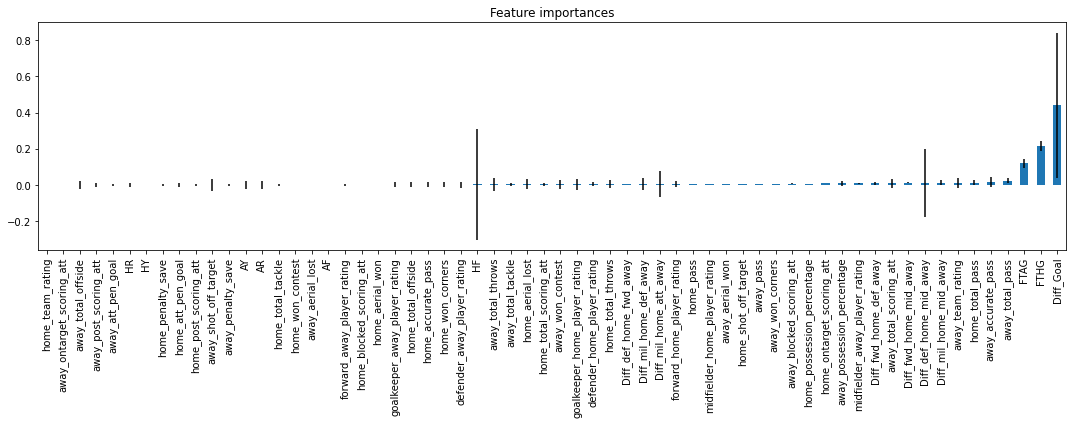

In [90]:
# The variable importance is plotted with its standard deviation for all trees considered
forest_NR = RandomForestClassifier(random_state=0, max_depth =3, n_estimators = 30)
forest_NR.fit(X_train_NR,y_train)

importances = forest_NR.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest_NR.estimators_], axis=0)
forest_importances = pd.Series(importances, index=X_train.columns.values)
forest_importances = forest_importances[forest_importances.argsort().values]

fig, ax = plt.subplots(figsize=(15,6))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_xticklabels(forest_importances.index, rotation='vertical')
ax.set_title("Feature importances")
fig.tight_layout()
plt.show()

In [91]:
# Score comparison between the test and train dataset (overfitting check)
print('Score on (Test, Train) datasets, Non reduced Dataset (NR): (',grid_forest_NR.score(X_train_NR, y_train),' ,', grid_forest_NR.score(X_test, y_test) ,' )')
print('Score on (Test, Train) datasets, Selected Features (FS): (', grid_forest_FS.score(X_train_FS, y_train),' ,', grid_forest_FS.score(X_test_FS, y_test) ,' )')
print('Score on (Test, Train) datasets, Reduced Dataset (R): (',grid_forest_R.score(X_train_R, y_train),' ,' ,grid_forest_R.score(X_test_R, y_test) ,' )')

Score on (Test, Train) datasets, Non reduced Dataset (NR): ( 1.0  , 1.0  )
Score on (Test, Train) datasets, Selected Features (FS): ( 1.0  , 1.0  )
Score on (Test, Train) datasets, Reduced Dataset (R): ( 1.0  , 0.7327327327327328  )


##  2.6 XG Boost

In [92]:
# Target is converted in numerical variable: H = 1, D = 0, A=-1
y_train_xgb = y_train.replace({'H': 1, 'D': 0, 'A': -1})
y_test_xgb  =  y_test.replace({'H': 1, 'D': 0, 'A': -1})

In [94]:
import xgboost as xgb

train_xgb = xgb.DMatrix(data=X_train, label=y_train_xgb)

train_xgb_NR = xgb.DMatrix(data=X_train_NR, label=y_train_xgb)
test_xgb_NR  = xgb.DMatrix(data=X_test_NR, label=y_test_xgb)

train_xgb_FS = xgb.DMatrix(data=X_train_FS, label=y_train_xgb)
test_xgb_FS  = xgb.DMatrix(data=X_test_FS, label=y_test_xgb)

train_xgb_R = xgb.DMatrix(data=X_train_R, label=y_train_xgb)
test_xgb_R  = xgb.DMatrix(data=X_test_R, label=y_test_xgb)

In [95]:
X_train.head()

,home_team_rating,home_won_contest,home_possession_percentage,home_total_throws,home_blocked_scoring_att,home_total_scoring_att,home_total_tackle,home_aerial_won,home_aerial_lost,home_accurate_pass,home_total_pass,home_won_corners,home_shot_off_target,home_ontarget_scoring_att,home_total_offside,home_post_scoring_att,home_att_pen_goal,home_penalty_save,HF,HY,HR,home_pass,goalkeeper_home_player_rating,defender_home_player_rating,midfielder_home_player_rating,forward_home_player_rating,FTHG,away_team_rating,away_won_contest,away_possession_percentage,away_total_throws,away_blocked_scoring_att,away_total_scoring_att,away_total_tackle,away_aerial_won,away_aerial_lost,away_accurate_pass,away_total_pass,away_won_corners,away_shot_off_target,away_ontarget_scoring_att,away_total_offside,away_post_scoring_att,away_att_pen_goal,away_penalty_save,AF,AY,AR,away_pass,goalkeeper_away_player_rating,defender_away_player_rating,midfielder_away_player_rating,forward_away_player_rating,FTAG,Diff_def_home_fwd_away,Diff_def_home_mid_away,Diff_mil_home_att_away,Diff_mil_home_mid_away,Diff_mil_home_def_away,Diff_fwd_home_mid_away,Diff_fwd_home_def_away,Diff_Goal
match_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
829623,-1.316954,-0.406945,-0.938463,1.608173,1.043193,0.156337,-1.083059,-0.255137,1.906644,-1.068921,-1.063182,-0.132083,0.384561,-0.995916,-0.075117,1.340649,-0.612528,-0.185020,-0.036332,2.383038,-0.431327,-0.961924,-1.237994,-0.256375,-1.326425,-0.647115,-0.405359,-0.737294,-1.221179,0.017558,0.243331,0.442277,0.311826,-1.516931,0.596153,0.423348,0.057071,0.095712,-0.900837,0.109606,0.145772,0.465333,-0.718538,-0.511198,-0.263486,0.836616,0.673522,-0.524516,0.040560,-0.049637,0.024218,-0.794066,-1.091088,-0.138724,0.832769,0.443494,0.222376,-0.366441,0.222376,-0.128417,0.304870,-0.200602
829645,-0.414332,1.408884,0.986678,2.017190,1.874579,0.421119,-0.168973,-0.934003,-1.148223,0.723592,0.578608,1.024511,-0.987550,0.151094,1.286551,-0.872310,-0.612528,-0.185020,0.118469,1.014964,-0.431327,1.183416,0.204220,-0.716830,0.040748,-1.201352,-0.405359,-0.365336,-0.056396,-0.273210,-0.187883,-0.300063,-0.447767,0.878046,1.435750,-0.056520,-0.531251,-0.696991,-0.485323,-0.349543,-0.333090,0.465333,-0.718538,-0.511198,-0.263486,1.144973,1.107870,-0.524516,0.139741,-0.976436,-1.105390,0.347482,0.827279,-1.008582,-1.067063,-0.747432,-0.676131,-0.219695,-0.676131,-1.193801,-1.441398,0.361197
829649,0.368265,-0.179966,0.712843,-1.336753,0.835347,1.215464,-0.717425,-1.001890,-0.085660,0.937314,0.708794,1.354967,1.560655,0.342262,-1.777202,0.234170,-0.612528,5.404824,1.047276,1.470989,-0.431327,1.463842,1.311777,-0.476205,0.528257,0.208176,1.164127,0.456955,-0.691733,-0.968694,-0.705341,-1.289849,-1.315872,0.973845,1.295817,-0.193625,-0.741620,-0.849016,-2.562896,-0.808693,-0.811951,-0.957788,-0.718538,-0.511198,-0.263486,1.915865,1.107870,-0.524516,-0.187623,0.594520,1.626861,0.177889,-0.508224,-1.008582,0.217324,-0.455550,0.706371,0.244835,0.706371,0.081990,0.506509,1.484794
829653,0.713035,-0.633924,-1.432196,1.608173,-0.203885,-0.020184,0.653704,1.238370,2.105875,-1.348140,-1.240380,-0.297310,0.384561,-0.231243,-0.075117,2.447129,-0.612528,-0.185020,-0.345935,0.558939,-0.431327,-1.756751,0.578717,0.468471,0.093452,0.562420,1.164127,-1.273239,-0.691733,-0.398947,1.623218,-0.794956,-1.424386,-0.175744,-0.173477,0.354796,-0.096249,-0.103369,-0.277565,-1.038268,-1.290812,-0.602007,0.501875,-0.511198,-0.263486,0.374080,-0.195173,-0.524516,0.018467,-1.660031,-0.075119,-1.320265,-0.853184,0.731135,0.971007,1.334606,0.768557,1.009571,0.768557,1.166006,1.002617,0.361197
829661,-0.860681,0.273991,-1.262086,-0.518718,-0.203885,-1.255832,1.110747,-0.255137,0.844082,-1.020661,-1.055949,-0.462538,-1.575597,-0.995916,0.265300,-0.872310,-0.612528,-0.185020,-0.036332,1.014964,-0.431327,-0.818021,-0.154342,-0.921807,-0.613886,0.051798,-1.190101,0.639804,1.531944,0.614810,-0.274126,0.194830,0.420339,0.303252,-1.013074,-1.016256,1.144574,1.007863,0

In [96]:

param_CV = {'max_depth': range(2, 3, 5), 'num_boost_round': [10, 30, 50, 100], 'learning_rate': [0.005, 0.01, 0.05]}


xgb_ini_NR = xgb.XGBClassifier(objective='multi:softprob')
xgb_ini_FS = xgb.XGBClassifier(objective='multi:softprob')
xgb_ini_R = xgb.XGBClassifier(objective='multi:softprob')

grid_xgb_NR = GridSearchCV(estimator=xgb_ini_NR, param_grid=param_CV, scoring = 'f1', cv = 4)
grid_xgb_FS = GridSearchCV(estimator=xgb_ini_FS, param_grid=param_CV, scoring = 'f1', cv = 4)
grid_xgb_R = GridSearchCV(estimator=xgb_ini_R, param_grid=param_CV, scoring = 'f1', cv = 4)

grid_xgb_NR.fit(X_train_NR,y_train)
grid_xgb_FS.fit(X_train_FS,y_train)
grid_xgb_R.fit(X_train_R,y_train)

/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:01:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:01:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:01:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:01:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:01:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:01:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:01:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:01:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:01:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:01:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:01:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:01:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:01:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:01:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:01:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:01:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:01:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:01:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:01:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:01:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:01:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:01:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:01:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:01:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:01:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:01:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:01:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:01:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:01:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:01:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:01:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:01:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:01:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:01:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:01:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:01:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:01:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:01:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:02:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:02:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:02:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:03:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:03:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:03:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:03:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:03:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:03:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:03:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:03:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:03:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:03:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:03:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:03:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:03:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:03:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:03:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:03:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:03:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:03:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:03:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:03:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:03:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:03:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:03:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:03:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:03:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:03:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:03:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:03:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:03:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:03:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:03:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:03:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:03:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:03:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:03:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:03:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:03:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:03:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:03:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:03:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:03:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:03:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:03:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:03:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:03:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:03:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:03:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:03:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:03:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:03:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:03:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:03:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:04:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:04:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:04:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:04:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:04:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:04:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:04:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:04:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:04:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:04:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:04:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:04:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:04:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:04:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:04:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:04:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:04:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:04:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:04:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:04:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective='multi:softprob', predictor=None,
                                     random_state=None, reg_alpha=None,
     

In [97]:
print('Best parameters, non reduced dataset:',grid_xgb_NR.best_params_) 
print('Best parameters, dataset with feature reduction:',grid_xgb_FS.best_params_) 
print('Best parameters, reduced dataset:',grid_xgb_R.best_params_) 
# No out of bounds values could be found

Best parameters, non reduced dataset: {'learning_rate': 0.005, 'max_depth': 2, 'num_boost_round': 10}
Best parameters, dataset with feature reduction: {'learning_rate': 0.005, 'max_depth': 2, 'num_boost_round': 10}
Best parameters, reduced dataset: {'learning_rate': 0.005, 'max_depth': 2, 'num_boost_round': 10}


In [98]:
y_pred_u_xgb_NR = grid_xgb_NR.predict(X_test_NR)
y_pred_u_xgb_FS = grid_xgb_FS.predict(X_test_FS)
y_pred_u_xgb_R  = grid_xgb_R.predict(X_test_R)

y_pred_train_u_xgb_NR = grid_xgb_NR.predict(X_train_NR)
y_pred_train_u_xgb_FS = grid_xgb_FS.predict(X_train_FS)
y_pred_train_u_xgb_R  = grid_xgb_R.predict(X_train_R)

In [99]:
# Classification reports / The reduced dataset gives better performences / No Draws predicted
print('Non reduced Dataset (NR):')
print(classification_report(y_test, y_pred_u_xgb_NR))
print('Dataset with selected features (FS):')
print(classification_report(y_test, y_pred_u_xgb_FS))
print('Reduced Dataset (R):')
print(classification_report(y_test, y_pred_u_xgb_R))

Non reduced Dataset (NR):
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        92
           D       1.00      1.00      1.00        89
           H       1.00      1.00      1.00       152

    accuracy                           1.00       333
   macro avg       1.00      1.00      1.00       333
weighted avg       1.00      1.00      1.00       333

Dataset with selected features (FS):
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        92
           D       1.00      1.00      1.00        89
           H       1.00      1.00      1.00       152

    accuracy                           1.00       333
   macro avg       1.00      1.00      1.00       333
weighted avg       1.00      1.00      1.00       333

Reduced Dataset (R):
              precision    recall  f1-score   support

           A       0.61      0.76      0.68        92
           D       0.35      0.19      0.25  

In [100]:
print('Non reduced Dataset (NR):')
pd.crosstab(y_test, y_pred_u_xgb_NR, rownames=['Real'], colnames=['Predicted'])

Non reduced Dataset (NR):


Predicted,A,D,H
Real,,,
A,92,0,0
D,0,89,0
H,0,0,152


In [101]:
print('Dataset with selected features (FS):')
pd.crosstab(y_test, y_pred_u_xgb_FS, rownames=['Real'], colnames=['Predicted'])

Dataset with selected features (FS):


Predicted,A,D,H
Real,,,
A,92,0,0
D,0,89,0
H,0,0,152


In [102]:
print('Reduced Dataset (R):')
pd.crosstab(y_test, y_pred_u_xgb_R, rownames=['Real'], colnames=['Predicted'])

Reduced Dataset (R):


Predicted,A,D,H
Real,,,
A,70,14,8
D,34,17,38
H,11,17,124


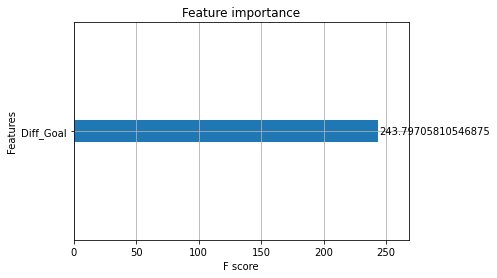

In [103]:
#Feature importance is plotted via the parameter importance type: 'Gain' and 'weight' (mean reduction of the loss function between nodes).
xgb.plot_importance(grid_xgb_NR.best_estimator_, max_num_features=15, importance_type = 'gain');

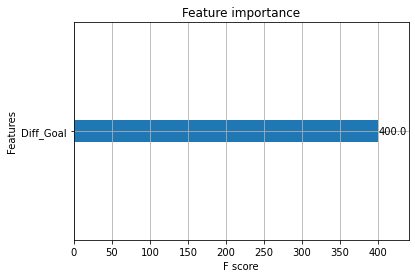

In [104]:
xgb.plot_importance(grid_xgb_NR.best_estimator_, max_num_features=15, importance_type = 'weight');

In [105]:
# Score comparison between the test and train dataset (overfitting check)
from sklearn.metrics import accuracy_score

print('Score on (Test, Train) datasets, Non reduced Dataset (NR): (',accuracy_score(y_train, y_pred_train_u_xgb_NR),' ,', accuracy_score(y_test, y_pred_u_xgb_NR),' )')
print('Score on (Test, Train) datasets, Selected Features (FS): (', accuracy_score(y_train, y_pred_train_u_xgb_FS),' ,', accuracy_score(y_test, y_pred_u_xgb_FS) ,' )')
print('Score on (Test, Train) datasets, Reduced Dataset (R): (',accuracy_score(y_train, y_pred_train_u_xgb_R),' ,' , accuracy_score(y_test, y_pred_u_xgb_R),' )')

Score on (Test, Train) datasets, Non reduced Dataset (NR): ( 1.0  , 1.0  )
Score on (Test, Train) datasets, Selected Features (FS): ( 1.0  , 1.0  )
Score on (Test, Train) datasets, Reduced Dataset (R): ( 0.7141424272818455  , 0.6336336336336337  )


##  2.7 Voting Classifier

In [106]:
# Voting Classifier with 'soft' vote considering that our models are well parametrized
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.metrics import f1_score
 
vclf_NR = VotingClassifier(estimators=[('cfl', grid_clf_NR), ('knn', grid_knn_NR), ('svm', grid_clf_svm_NR), 
                                       ('dtc_boost', ac_NR), ('Rforest', grid_forest_NR), ('XGB', grid_xgb_NR)], voting='soft')
vclf_FS = VotingClassifier(estimators=[('cfl', grid_clf_FS), ('knn', grid_knn_FS), ('svm', grid_clf_svm_NR), 
                                       ('dtc_boost', ac_FS), ('Rforest', grid_forest_FS), ('XGB', grid_xgb_FS)], voting='soft')
vclf_R  = VotingClassifier(estimators=[ ('cfl', grid_clf_R), ('knn', grid_knn_R) , ('svm', grid_clf_svm_NR), 
                                       ('dtc_boost',ac_R), ('Rforest', grid_forest_R), ('XGB', grid_xgb_R)], voting='soft')

In [107]:
# Performances:
vclf_NR.fit(X_train_NR, y_train)
vclf_FS.fit(X_train_FS, y_train)
vclf_R.fit(X_train_R, y_train)

y_pred_vcfl_NR = vclf_NR.predict(X_test_NR)
y_pred_vcfl_FS = vclf_FS.predict(X_test_FS)
y_pred_vcfl_R  = vclf_R.predict(X_test_R)

#pd.crosstab(y_test, y_pred_vcfl, rownames=['Classe réelle'], colnames=['Classe prédite'])

/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/

[20:09:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:09:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:09:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:09:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:09:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:09:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:09:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:09:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:09:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:09:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:09:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:09:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:09:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:09:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:09:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:09:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:09:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:09:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:09:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:09:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:09:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:09:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:09:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:09:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:09:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:09:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:09:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:09:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:09:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:09:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:09:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:09:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:09:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:09:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:09:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:09:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:09:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:09:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:09:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:09:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:09:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:09:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:09:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:09:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:09:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:09:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:09:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:09:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:09:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/

[20:10:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:10:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:10:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but 

/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:10:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:10:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:10:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but 

/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:10:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:10:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:10:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:10:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:10:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:10:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:10:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:10:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:10:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:10:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:10:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:10:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:10:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:10:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:10:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:10:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:10:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:10:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:10:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but 

/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:10:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:10:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:10:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:10:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:10:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:10:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:10:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:10:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:10:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:10:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:10:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:10:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:10:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:10:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:10:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:10:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:10:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:10:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:10:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:10:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:10:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:10:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:10:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:10:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:10:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:10:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:10:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:10:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:10:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:10:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:10:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:10:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:10:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:10:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:10:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:10:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:10:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:10:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:10:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:10:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:10:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:10:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:10:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:10:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:10:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:10:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:10:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:10:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:10:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:10:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:10:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:10:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:10:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:10:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:10:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:10:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:10:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:10:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:10:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:10:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:10:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:10:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:10:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:10:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:10:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:10:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:10:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:10:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:10:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:10:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:10:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:11:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:11:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:11:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:11:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:11:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:11:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:11:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:11:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:11:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:11:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:11:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:11:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:11:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:11:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:11:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:11:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:11:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:11:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:11:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:11:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:11:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:11:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:11:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:11:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:11:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:11:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:11:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:11:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:11:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:11:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:11:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:11:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:11:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:11:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:11:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:11:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:11:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:11:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:11:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:11:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:11:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:11:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:11:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:11:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:11:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:11:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:11:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:11:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklea

[20:11:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [108]:
# Classification reports / Results for the 3 datasets are similars / No Draws predicted
print('Non reduced Dataset (NR):')
print(classification_report(y_test, y_pred_vcfl_NR))
print('Dataset with selected features (FS):')
print(classification_report(y_test, y_pred_vcfl_FS))
print('Reduced Dataset (R):')
print(classification_report(y_test, y_pred_vcfl_R))

Non reduced Dataset (NR):
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        92
           D       1.00      1.00      1.00        89
           H       1.00      1.00      1.00       152

    accuracy                           1.00       333
   macro avg       1.00      1.00      1.00       333
weighted avg       1.00      1.00      1.00       333

Dataset with selected features (FS):
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        92
           D       1.00      1.00      1.00        89
           H       1.00      1.00      1.00       152

    accuracy                           1.00       333
   macro avg       1.00      1.00      1.00       333
weighted avg       1.00      1.00      1.00       333

Reduced Dataset (R):
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        92
           D       1.00      0.98      0.99  

In [109]:
print('Non reduced Dataset (NR):')
pd.crosstab(y_test, y_pred_vcfl_NR, rownames=['Real'], colnames=['Predicted'])

Non reduced Dataset (NR):


Predicted,A,D,H
Real,,,
A,92,0,0
D,0,89,0
H,0,0,152


In [110]:
print('Dataset with selected features (FS):')
pd.crosstab(y_test, y_pred_vcfl_FS, rownames=['Real'], colnames=['Predicted'])

Dataset with selected features (FS):


Predicted,A,D,H
Real,,,
A,92,0,0
D,0,89,0
H,0,0,152


In [111]:
print('Reduced Dataset (R):')
pd.crosstab(y_test, y_pred_vcfl_R, rownames=['Real'], colnames=['Predicted'])

Reduced Dataset (R):


Predicted,A,D,H
Real,,,
A,92,0,0
D,0,87,2
H,0,0,152


In [112]:
# Score comparison between the test and train dataset (overfitting check)
print('Score on (Test, Train) datasets, Non reduced Dataset (NR): (',vclf_NR.score(X_train_NR, y_train),' ,' ,vclf_NR.score(X_test_NR, y_test), ' )')
print('Score on (Test, Train) datasets, Selected Features (FS): (', vclf_FS.score(X_train_FS, y_train),' ,', vclf_FS.score(X_test_FS, y_test) ,' )')
print('Score on (Test, Train) datasets, Reduced Dataset (R): (',vclf_R.score(X_train_R, y_train),' ,', vclf_R.score(X_test_R, y_test) ,' )')

Score on (Test, Train) datasets, Non reduced Dataset (NR): ( 1.0  , 1.0  )
Score on (Test, Train) datasets, Selected Features (FS): ( 1.0  , 1.0  )
Score on (Test, Train) datasets, Reduced Dataset (R): ( 1.0  , 0.993993993993994  )


# 3 Comparaisons

XGBoost with reduced dataset seems to gives the performeaces: 0.51 f1-score for 'A' and 0.67 for 'H'and 0.10 for 'D'
This results can be compared with the best bookmaker predictions. 
From the odds, the prediction of each bookmaker is deduced (that is the lowest odd). Then using the match results, classification reports are computed in order to select the best bookmaker and compare its results with our best model.

The accuracy for the dataset with selected features is 0.54 which is better than the accuracy obtained by the model presented in:https://vgalle.github.io/files/BettingReport.pdf concerning the outcome of the group stage of the football world cup (accuracy of 0.5).


In [113]:
df_bookmakers = pd.read_csv('df_stats_cotes.csv', index_col = 0)
df_bookmakers = df_bookmakers.reset_index(drop=True).set_index('match_id')
df_bookmakers = df_bookmakers.drop('index',1)

FileNotFoundError: [Errno 2] No such file or directory: 'df_stats_cotes.csv'

In [ ]:
df_bookmakers.head()

,season,date,away_team_id,away_team_name,home_team_id,home_team_name,home_team_rating,home_won_contest,home_possession_percentage,home_total_throws,home_blocked_scoring_att,home_total_scoring_att,home_total_tackle,home_aerial_won,home_aerial_lost,home_accurate_pass,home_total_pass,home_won_corners,home_shot_off_target,home_ontarget_scoring_att,home_total_offside,home_post_scoring_att,home_att_pen_goal,home_penalty_save,HF,HY,HR,home_pass,goalkeeper_home_player_rating,defender_home_player_rating,midfielder_home_player_rating,forward_home_player_rating,FTHG,away_team_rating,away_won_contest,away_possession_percentage,away_total_throws,away_blocked_scoring_att,away_total_scoring_att,away_total_tackle,away_aerial_won,away_aerial_lost,away_accurate_pass,away_total_pass,away_won_corners,away_shot_off_target,away_ontarget_scoring_att,away_total_offside,away_post_scoring_att,away_att_pen_goal,away_penalty_save,AF,AY,AR,away_pass,goalkeeper_away_player_rating,defender_away_player_rating,midfielder_away_player_rating,forward_away_player_rating,FTAG,FTR,B365H,B365D,B365A,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,VCH,VCD,VCA,PSCH,PSCD,PSCA,B365R,LBR,PSR,WHR,VCR,PSCR,BestH,BestD,BestA
match_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
829513,2014_2015,2014-08-16,162,Crystal Palace,13,Arsenal,7.015000,12.0,76.0,21.0,3.0,14.0,26.0,23.0,17.0,640.0,730.0,9.0,5.0,6.0,0.0,0.0,0.0,0.0,13,2,0,0.876712,5.81,7.277500,7.556,6.420,2,6.628571,7.0,24.0,18.0,2.0,4.0,33.0,17.0,23.0,127.0,222.0,3.0,0.0,2.0,1.0,0.0,0.0,0.0,19,2,1,0.572072,6.26,6.950000,6.8125,6.825,1,H,1.25,6.5,15.0,1.25,6.00,13.00,1.26,6.45,14.01,1.25,5.5,12.0,1.25,6.25,10.50,1.29,5.90,12.75,H,H,H,H,H,H,1.29,6.5,15.00
829515,2014_2015,2014-08-16,31,Everton,14,Leicester,6.714286,6.0,36.7,12.0,3.0,11.0,13.0,27.0,14.0,265.0,344.0,3.0,5.0,3.0,0.0,0.0,0.0,0.0,16,1,0,0.770349,6.39,6.937500,6.520,7.005,2,6.610000,9.0,63.3,17.0,5.0,13.0,19.0,14.0,27.0,509.0,605.0,6.0,5.0,3.0,0.0,0.0,0.0,0.0,10,1,0,0.841322,6.03,6.560000,7.0600,6.320,2,D,3.20,3.4,2.4,3.25,3.40,2.25,3.14,3.38,2.46,3.10,3.1,2.4,3.20,3.40,2.40,3.11,3.40,2.47,A,A,A,A,A,A,3.25,3.4,2.47
829517,2014_2015,2014-08-16,259,Swansea,32,Manchester United,6.707143,13.0,59.6,29.0,4.0,14.0,13.0,20.0,10.0,482.0,558.0,4.0,5.0,5.0,1.0,1.0,0.0,0.0,14,2,0,0.863799,5.79,7.076667,6.550,7.050,1,6.886429,4.0,40.4,23.0,1.0,5.0,19.0,10.0,20.0,307.0,383.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,20,4,0,0.801567,7.34,6.785000,7.2560,6.500,2,A,1.36,5.0,11.0,1.36,5.00,10.00,1.37,5.10,10.60,1.36,4.5,9.0,1.36,5.20,10.00,1.45,4.81,8.25,H,H,H,H,H,H,1.45,5.2,11.00
829519,2014_2015,2014-08-16,214,Hull,171,Queens Park Rangers,6.715000,8.0,51.0,22.0,6.0,19.0,14.0,30.0,15.0,296.0,383.0,8.0,7.0,6.0,0.0,0.0,0.0,0.0,10,1,0,0.772846,6.88,7.096667,6.776,6.655,0,7.176429,4.0,49.0,26.0,4.0,11.0,17.0,15.0,30.0,289.0,382.0,9.0,3.0,4.0,2.0,0.0,0.0,1.0,10,2,0,0.756545,8.92,8.013333,7.2775,6.330,1,A,2.50,3.3,3.1,2.40,3.25,3.10,2.48,3.26,3.22,2.60,3.0,2.9,2.55,3.20,3.12,2.31,3.24,3.59,H,H,H,H,H,H,2.60,3.3,3.59
829520,2014_2015,2014-08-16,24,Aston Villa,96,Stoke,6.799231,9.0,63.1,36.0,6.0,12.0,27.0,30.0,9.0,432.0,517.0,2.0,4.0,2.0,1.0,0.0,0.0,0.0,14,0,0,0.835590,5.73,7.450000,6.770,6.590,0,6.767692,4.0,36.9,35.0,2.0,7.0,19.0,9.0,30.0,197.0,289.0,8.0,4.0,1.0,1.0,0.0,0.0,0.0,9,3,0,0.681661,6.30,7.087500,6.9820,6.200,1,A,1.95,3.5,4.5,1.95,3.40,4.20,1.95,3.47,4.55,1.95,3.2,4.2,1.95,3.30,4.75,2.01,3.34,4.51,H,H,H,H,H,H,2.01,3.5,4.75


In [ ]:
bookmaker_list = ['B365', 'LB', 'PS', 'WH', 'VC', 'PSC']

In [ ]:
y_pred_bookmaker = df_bookmakers[df_bookmakers['season']=='2017_2018'][bookmaker_list[0]+'R'].reset_index(drop=True)
y_test_bookmaker = df_bookmakers[df_bookmakers['season']=='2017_2018'][target_list].reset_index(drop=True)

In [ ]:
for pos, bookies in enumerate(bookmaker_list):
  y_pred_bookmaker = df_bookmakers[df_bookmakers['season']=='2017_2018'][bookies+'R'].reset_index(drop=True)
  print(bookies)  
  print(classification_report(y_test_bookmaker, pd.DataFrame(y_pred_bookmaker)))

B365
              precision    recall  f1-score   support

           A       0.54      0.56      0.55       108
           D       0.00      0.00      0.00        99
           H       0.56      0.87      0.68       173

    accuracy                           0.55       380
   macro avg       0.37      0.47      0.41       380
weighted avg       0.41      0.55      0.46       380

LB
              precision    recall  f1-score   support

           A       0.53      0.56      0.54       108
           D       0.00      0.00      0.00        99
           H       0.56      0.87      0.68       173

    accuracy                           0.55       380
   macro avg       0.36      0.47      0.41       380
weighted avg       0.41      0.55      0.46       380

PS
              precision    recall  f1-score   support

           A       0.53      0.56      0.54       108
           D       0.00      0.00      0.00        99
           H       0.56      0.86      0.68       173

    accur

C:\Users\miras\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\miras\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\miras\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\miras\anaconda3\lib\site-packages\sklearn\metr

B365 and WH have the best results, they both have a f1-score of 0.55 for 'A' and 0.68 for 'H'.
Voting Classifier has a 0.52 f1-score for 'A' and 0.66 for 'H'and 0.26 for 'D'.

From the results is section 2 and 3, the following observations can be made:
- Classification models used have difficulties to predict draws
- Results are similar to Bookmakers predictions (where no draws are predicted) but are never superior
- The voting classifier seems to be our best model when considering the f1-score
- Results for reduced datasets (FS or R) are similar to non reduced model which makes the reduced dataset interesting to use
- When it has been possible, the importance of variables where studied: the number of passes are often among the most important feature. The rating (differences between strikers and defense for instance) can also impact the classification result, in a less important way.